In [1]:
%load_ext autoreload
%autoreload 2

import torch
from timeit import default_timer
device = torch.device("cuda")
import torch.nn as nn
import numpy as np
import imageio
import matplotlib.pyplot as plt
from src.preprocessing import *
from torch.utils.data.sampler import SubsetRandomSampler
from prettytable import PrettyTable

In [2]:
data_path = "./data/"
radar_data = np.load(f'{data_path}/radars_2020-11-01_2022-12-31.npy')

actual_mask = radar_data > (abs(np.min(radar_data,axis=(1,2))).reshape(-1,1,1))
radar_data *= actual_mask
radar_data = min_max_scaller(radar_data)

glorys     = np.load(f'{data_path}/glorys_2020-11-01_2022-12-31.npy')
gfs = np.load(f'{data_path}/gfs_2020-11-01_2022-12-31.npy')
mask = load_mask(data_path+'mask.png')

print('radar data : ', radar_data.shape)
print('glorys data :', glorys.shape)
print('gfs data :', gfs.shape)

radar data :  (791, 825, 200)
glorys data : (791, 3, 825, 200)
gfs data : (791, 3, 825, 200)


In [3]:
dat = generate_weather_data(radar_data, mask,gfs, glorys)
dat.pop(59)
dataset = Weather_Dataset(dat)
batch_size = 2
validation_split = 0.2
shuffle_dataset = True 
random_seed = 42

dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset: 
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_idxs , test_idxs = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idxs)
test_sampler = SubsetRandomSampler(test_idxs)

train_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, sampler = train_sampler)
test_loader  = torch.utils.data.DataLoader(dataset, batch_size = batch_size, sampler = test_sampler)

input_data, target_difference, days_mask, target_idx = next(iter(train_loader))

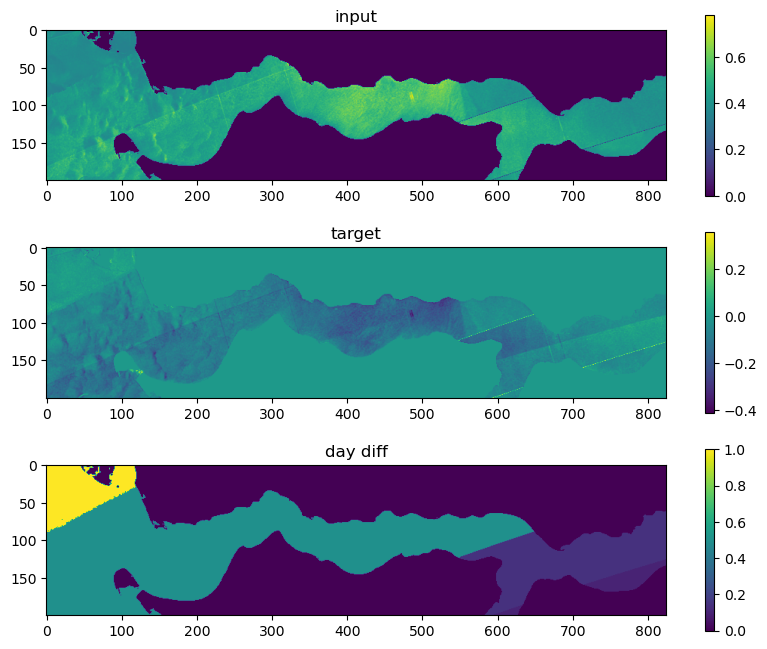

In [4]:
idx = 1
plt.figure(figsize=(10,8))
plt.subplot(3,1,1)
plt.imshow(input_data[idx,0].T)
plt.colorbar()
plt.title('input')
plt.subplot(3,1,2)
plt.imshow(target_difference[idx,0].T);
plt.colorbar()
plt.title('target')
plt.subplot(3,1,3)
plt.imshow(days_mask[idx,0].T)
plt.title('day diff')
plt.colorbar()
plt.show()

In [8]:
from radars.UNet import UNet
USE_WANDB = False

model = UNet(8, 1, False, 3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

if USE_WANDB:
    import wandb
    wandb.init(
        # set the wandb project where this run will be logged
        project="ice_tracking",
        # track hyperparameters and run metadata
        config={
        "learning_rate": optimizer.param_groups[0]['lr'],
        "architecture": model._get_name(),
        "Optimizer": optimizer.__class__,
        "info": 'simple unet',
        }
    )

AssertionError: Torch not compiled with CUDA enabled

In [108]:
def prepare_images(x_input, y_output, y_target):
    plt.figure(figsize=(10,8))
    
    plt.subplot(4,1,1)
    plt.imshow(x_input[0,0].T);
    plt.xticks([]); plt.yticks([])
    plt.ylabel('Input', fontsize = 13)
    plt.colorbar(pad = 0.01, shrink = 0.7)

    plt.subplot(4,1,2)
    plt.imshow(y_output[0][0].T);
    plt.xticks([]); plt.yticks([])
    plt.ylabel('Output', fontsize = 13)
    plt.colorbar(pad = 0.01, shrink = 0.7)

    plt.subplot(4,1,3)
    plt.imshow(y_target[0][0].T);
    plt.xticks([]); plt.yticks([])
    plt.ylabel('Target', fontsize = 13)
    plt.colorbar(pad = 0.01, shrink = 0.7)

    plt.subplot(4,1,4)
    plt.imshow(abs(y_output[0][0].T - y_target[0][0].T));
    plt.xticks([]); plt.yticks([])
    plt.ylabel('Difference', fontsize = 13)
    plt.colorbar(pad = 0.01, shrink = 0.7)

    plt.subplots_adjust(wspace=0, hspace=0)
    f = plt.gcf()
    plt.close()

    return f


In [12]:
def fo(x):
    return np.round(x, 5)

def train(device, model, optimizer, trainloader, epochs = 20, evalloader=False, name_experiment='model_test', USE_WANDB = False):
    train_loss_list = []
    valid_loss_list = []
    grad_list = []
    
    best_val_loss = 1000;

    for ep in range(epochs):
        percent_epoch  = ep/epochs
        model.train()
        t_1 = default_timer()
        train_pred_full = 0
        total_grad = 0
        for input_data, target_difference, days_mask, target_idx in trainloader:
            
            x_train = torch.cat((input_data, days_mask), dim = 1)
            y_train = target_difference
            
            l_recons = 0
            x_train = x_train.type(torch.float32).to(device)
            y_train = y_train.type(torch.float32).to(device)
            
            bs = x_train.shape[0]
            pred = model(x_train)
            loss = torch.nn.functional.mse_loss(pred.reshape(bs, -1),y_train.reshape(bs, -1) )

            train_pred_full += loss.item()

            optimizer.zero_grad()
            loss.backward()
            grad_by_batch  =  0
            for tag, value in model.named_parameters():
                if value.grad is not None:
                    grad =  value.grad.norm()
                    total_grad += grad 
                    grad_by_batch += grad

            optimizer.step()
            
        grad_list.append(total_grad.cpu().item())

        train_pred_full = train_pred_full / len(trainloader)

        train_loss_list.append(train_pred_full)

        t2 = default_timer()
        valid_pred_full = 0

        if evalloader:
            model.eval()
            with torch.no_grad():
                for input_data, target_difference, days_mask, target_idx in evalloader:

                    x_valid = torch.cat((input_data, days_mask), dim = 1)
                    y_valid = target_difference
                    
                    loss = 0
                    x_valid = x_valid.type(torch.float32).to(device)
                    y_valid = y_valid.type(torch.float32).to(device)
                    bs = x_valid.shape[0]
                    
                    pred = model(x_valid)

                    l_pred = torch.nn.functional.mse_loss(pred.reshape(bs, -1), y_valid.reshape(bs, -1))

                    valid_pred_full += l_pred.item()

            valid_pred_full = valid_pred_full / len(evalloader)

            valid_loss_list.append(valid_pred_full)

        # scheduler.step(loss)
        # scheduler.step()

        if USE_WANDB:
            f = prepare_images(x_valid.cpu().numpy(), pred.cpu().numpy(), y_valid.cpu().numpy() )
            wandb.log({'Results ': f})
            wandb.log({"Train MSE": train_pred_full, "Test MSE": valid_pred_full})
            wandb.log({"Total grad": total_grad.item(), "grad_by_batch": grad_by_batch.item() })
            # imag_pred = wandb.Image(pred, caption = "Preds")
            # imag_trag = wandb.Image(y_valid, caption = "Targets")
            # imag_diff = wandb.Image(pred - y_valid, caption = "Diff")               
            # wandb.log({"Preds": imag_pred, "Targets": imag_trag, "Diff": imag_diff,})

        if evalloader:
            if ep == 0:
                x = PrettyTable()
                x.field_names = ["Epoch", "Time", "Train Pred MSE", "Eval Pred MSE", "total grad", "grad_by_batch"]
                x.hrules = 1
            elif ep == 1:
                x.add_row([ep, fo(t2 - t_1), fo(train_pred_full), fo(valid_pred_full), fo(total_grad.item()), fo(grad_by_batch.item())], divider=False)
                print(x)
            elif ep % 1 == 0:
                x.add_row([ep, fo(t2 - t_1), fo(train_pred_full), fo(valid_pred_full), fo(total_grad.item()), fo(grad_by_batch.item())], divider=False)
                print( "\n".join(x.get_string().splitlines()[-2:-1]))
        
        if valid_pred_full < best_val_loss:
            best_val_loss = valid_pred_full
            torch.save(model.state_dict(), f"model.pth")
            
    return train_loss_list, valid_loss_list, grad_list

In [ ]:
train_loss_list, valid_loss_list, grad_list = train(device, model, optimizer, 
                                         train_loader, epochs = 300, 
                                         evalloader=test_loader, USE_WANDB = USE_WANDB)

In [ ]:
for x_test, y_test, days_mask, target_idx in test_loader:
    model.eval()
    x_test = x_test.to(device)
    days_mask = days_mask.to(device)
    x_test = torch.cat((x_test, days_mask), dim=1)
    with torch.no_grad():
        prediction = model(x_test.type(torch.float32))
    break

idx = 1
plt.figure(figsize=(32, 12))

plt.subplot(4,1,1)
plt.imshow(x_test[idx][0].squeeze().cpu().numpy().T)
plt.title("x input")
plt.colorbar()

plt.subplot(4,1,2)
plt.imshow(prediction[idx].cpu().numpy().T)
plt.title("prediction")
plt.colorbar()

plt.subplot(4,1,3)
plt.imshow(y_test[idx].cpu().numpy().T)
plt.title("ground truth")
plt.colorbar()

plt.subplot(4,1,4)
plt.imshow(np.abs(prediction[idx].cpu().squeeze().numpy().T - y_test[idx].cpu().squeeze().numpy().T))
plt.title("diff")
plt.colorbar()